In [1]:
%matplotlib inline


数据装载与处理教程
====================================

解决任何机器学习问题的许多努力都在准备数据。PyTorch 提供了许多工具来简化数据加载，并希望使您的代码更具可读性。在本教程中，我们将了解如何加载数据集和预处理/扩充数据。

请确保以下包已安装：

-  ``scikit-image``: 图像输入输出与变换
-  ``pandas``: 轻松地解析 csv




In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

plt.ion()  # 交互模式

我们要处理的数据集是面部姿势。面部是如下标注的：

.. figure:: /_static/img/landmarked_face2.png
   :width: 400

每个面部都共标注了68个不同的标记。

从[此处](https://download.pytorch.org/tutorial/faces.zip)下载数据集，图像在目录 faces/ 中。

这个数据集实际上是通过对来自 imagenet 标记为面部的一些[图像](http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html)，应用优秀的 dlib 的姿势估计生成的。

数据集中有带注释的 csv 文件，如下：

    image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
    0805personali01.jpg,27,83,27,98, ... 84,134
    1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

让我们快速读取CSV并在（N，2）数组中获取注释，N 是标记的数量。




In [3]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0] # iloc整数位置索引
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


让我们编写一个简单的辅助函数来显示图像及其标记，并用它来显示样本。



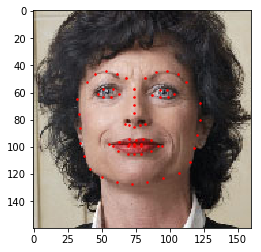

In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)  # 人脸图片
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    # 标记点：s：半径；marker：标记形式（点）；c：颜色
    plt.pause(0.001)  # 暂停片刻，等待图像更新


plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

数据集类
-------------

``torch.utils.data.Dataset`` 是一个表示数据集的抽象类。
自定义的数据集应该继承 ``Dataset`` 并重写以下方法：


-  ``__len__`` 在调用 ``len(dataset)`` 时返回数据集大小
-  ``__getitem__`` 以支持使用 ``dataset[i]`` 获取第i个样本的索引

让我们为面部标记数据集创建一个数据集类。
在 ``__init__`` 中读取 csv，但将读取图片的工作放在 ``__getitem__``. 这保证高效读取内存，因为所有图像不会立即存储在内存中，而是根据需要读取。

数据集中的样例是一个字典。
``{'image': image, 'landmarks': landmarks}``. 我们的数据集需要一个可选参数 ``transform``，以便任何所需的处理都可应用于样本。下一节中我们将看到 ``transform`` 的用处。




In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): 带有注释的 csv 文件的路径
            root_dir (string): 含所有图像的目录
            transform (callable, optional): 要应用于样本的可选变换
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)  # 由图片名读取图片
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

让我们初始化这个类并遍历数据样本。我们将打印前4个样本的大小并展示它们的标记点。




0 (324, 215, 3) (68, 2)


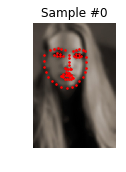

1 (500, 333, 3) (68, 2)


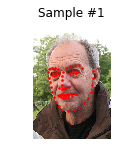

2 (250, 258, 3) (68, 2)


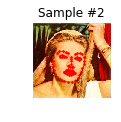

3 (434, 290, 3) (68, 2)


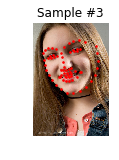

In [6]:
face_dataset = FaceLandmarksDataset(
    csv_file='faces/face_landmarks.csv', root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)  # subplot(nrows, ncols, index, **kwargs)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))  # 图片标题
    ax.axis('off')
    show_landmarks(**sample)  # 字典形式传参

    if i == 3:
        plt.show()
        break

变换
----------

上面可见的一个问题是样本图像不是同一大小的。大多数神经网络期望图像是固定大小的。因此，我们需要写一些预处理的代码。
让我们创建三个变换：

-  ``Rescale``: 缩放图像
-  ``RandomCrop``: 随机裁剪图像，这是数据增强的手段
-  ``ToTensor``: 将 numpy 图像转换为 torch 图像，需要交换轴

我们将把它们写作可调用的类，而不是简单的函数。因此变换的参数不需要在每次被调用时被传递。为此，我们只需实现 ``__call__`` 方法，如果有必要还包括 ``__init__`` 方法。使用变换的方式如下：

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

请注意以下这些变换如何应用于图像和标记：




In [7]:
class Rescale(object):
    """将样本中的图像重新缩放到给定大小。

    Args:
        output_size (tuple or int): 所需的输出大小。 
        如果是元组，则输出与 output_size 匹配。
        如果是int，则较小的图像边长与 output_size 匹配，保持纵横比相同。
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]  # 高与宽
        if isinstance(self.output_size, int):  # 如果 output_size 是整数
            if h > w:  # 如果高大于宽
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:  # 如果 output_size 是元组
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)  # 取整

        img = transform.resize(image, (new_h, new_w))

        # h 和 w 为标记而交换，因为对于图像，x 轴和 y 轴分别是轴 1 和轴 0
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """随机裁剪样本中的图像。

    Args:
        output_size (tuple or int): 所需的输出尺寸。如果为 int，则进行方形裁剪。
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)  # 随机裁剪
        left = np.random.randint(0, w - new_w)

        image = image[top:top + new_h, left:left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """将样本中的 n 维数组转换为 Tensor"""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # 交换颜色轴，因为
        # numpy 图像: H x W x C
        # torch 图像: C X H X W
        image = image.transpose((2, 0, 1))
        return {
            'image': torch.from_numpy(image),
            'landmarks': torch.from_numpy(landmarks)
        }

合成变换
~~~~~~~~~~~~~~~~~~

现在，我们将变换应用于样本。

假设我们想要将图像的短边重新缩放到256，然后从中随机裁剪一个大小为 224 的正方形。即我们要合成``Rescale``和``RandomCrop``变换。
``torchvision.transforms.Compose``是一个简单的可调用类，它允许我们去做这个。




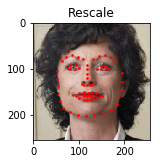

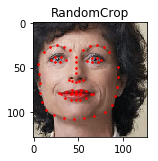

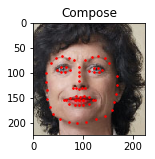

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# 在样本上应用上述每个变换。
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__) # 变换名称作为图的标题
    show_landmarks(**transformed_sample)

plt.show()

遍历数据集
-----------------------------

让我们把它们放在一起创建一个包含组合变换的数据集。
总之，每次对此数据集进行采样：

- 即时从文件中读取图像
- 变换应用于读取的图像
- 由于其中一个变换是随机的，数据在采样时被增强

我们可以像以前一样用 ``for i in range`` 循环遍历创建的数据集。

In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


但是，通过使用简单的``for``循环迭代数据，我们失去了很多功能。特别是，我们错过了：

- 批量处理数据
- 洗牌数据
- 并行加载数据。

``torch.utils.data.DataLoader``是一个提供所有这些功能的迭代器。下面使用的参数应该是清晰的。
一个重要的参数是``collate_fn``，您可以使用``collate_fn``指定样本如何分批处理
但是，对于大多数用例，默认应该可以正常工作。

In [10]:
dataloader = DataLoader(
    transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

# 展示一批数据的辅助函数
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(
            landmarks_batch[i, :, 0].numpy() + i * im_size,
            landmarks_batch[i, :, 1].numpy(),
            s=10,
            marker='.',
            c='r')

        plt.title('Batch from dataloader')


for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # 展示第4批后停止
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

BrokenPipeError: [Errno 32] Broken pipe

后记: torchvision
----------------------

在本教程中，我们已经了解了如何编写和使用数据集，转换和 dataloader.``torchvision``包提供了一些常见的数据集和
变换。您甚至可能不必编写自定义类。其中一个 torchvision 中可用的更通用的数据集是``ImageFolder``。
它假定图像按以下方式组织：

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

其中 'ants', 'bees' 等是类别的标签。类似在``PIL.Image``上运行的通用转换，如``RandomHorizontalFlip``，``Scale``，也是可用的。 你可以使用这些来写一个如下的 dataloader: 

      import torch
      from torchvision import transforms, datasets

      data_transform = transforms.Compose([
              transforms.RandomSizedCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
          ])
      hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                                 transform=data_transform)
      dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                                   batch_size=4, shuffle=True,
                                                   num_workers=4)

训练代码的样例，请见`transfer_learning_tutorial`.

